In [6]:
import os

import numpy as np
import pandas as pd

import pydicom
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import binary_crossentropy
from keras.utils import Sequence
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from glob import glob
from tqdm import tqdm

In [39]:
print(os.getcwd())
WORKING_DIR = os.getcwd()
INPUT_DIR = os.path.join(WORKING_DIR, "input")
print(INPUT_DIR)

SEGMENTATION_DIR = os.path.join(INPUT_DIR, "u-net-lung-segmentation-montgomery-shenzhen")
ILO_DIR = os.path.join(INPUT_DIR, "ILO_Standards")
NIH_DIR = os.path.join(INPUT_DIR, "NIH_Subset")
SEGMENTATION_MODEL = os.path.join(SEGMENTATION_DIR, "unet_lung_seg.hdf5")
SEGMENTATION_RESULT = os.path.join(WORKING_DIR, "segmentation")
SEGMENTATION_RESULT_MASKS = os.path.join(WORKING_DIR, "segmentation/results")
# SEGMENTATION_RESULT_TRAIN = os.path.join(SEGMENTATION_RESULT, "train")
# SEGMENTATION_RESULT_TEST = os.path.join(SEGMENTATION_RESULT, "test")



# RSNA_DIR = os.path.join(INPUT_DIR, "rsna-pneumonia-detection-challenge")
# RSNA_TRAIN_DIR = os.path.join(RSNA_DIR, "stage_1_train_images")
# RSNA_TEST_DIR = os.path.join(RSNA_DIR, "stage_1_test_images")
# RSNA_LABELS_FILE = os.path.join(RSNA_DIR, "stage_1_train_labels.csv")
# RSNA_CLASS_INFO_FILE = os.path.join(RSNA_DIR, "stage_1_detailed_class_info.csv")

/Users/white/Documents/AlexProjects/DICOM_OCC_MED/segmentation
/Users/white/Documents/AlexProjects/DICOM_OCC_MED/segmentation/input


In [18]:
!mkdir segmentation
!mkdir segmentation/results

mkdir: segmentation: File exists


In [21]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
print(SEGMENTATION_MODEL)
segmentation_model = load_model(SEGMENTATION_MODEL, \
                                custom_objects={'dice_coef_loss': dice_coef_loss, \
                                                'dice_coef': dice_coef})

segmentation_model.summary()

/Users/white/Documents/AlexProjects/DICOM_OCC_MED/segmentation/input/u-net-lung-segmentation-montgomery-shenzhen/unet_lung_seg.hdf5
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_58 (Conv2D)             (None, 512, 512, 32  320         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_59 (Conv2D)             (None, 512, 512, 32  9248  

In [15]:
def image_to_train(img):
    npy = img / 255
    npy = np.reshape(npy, npy.shape + (1,))
    npy = np.reshape(npy,(1,) + npy.shape)
    return npy

def train_to_image(npy):
    img = (npy[0,:, :, 0] * 255.).astype(np.uint8)
    return img

  0%|          | 0/22 [00:00<?, ?it/s]

4EF026C3
(4426, 4200)


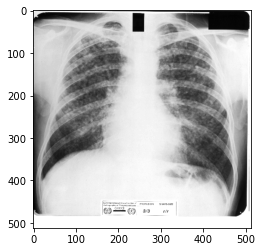

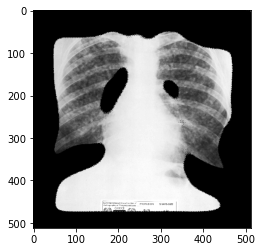

  0%|          | 0/22 [00:02<?, ?it/s]


-----------------------


  0%|          | 0/5 [00:00<?, ?it/s]

00000001_001
(1024, 1024)


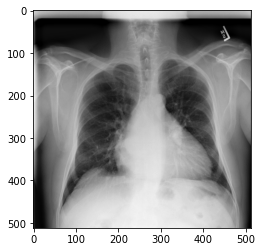

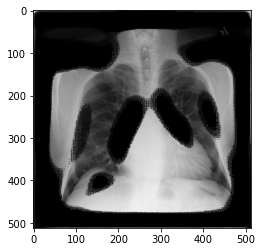

  0%|          | 0/5 [00:02<?, ?it/s]


In [48]:
def segment_image(pid, img, save_to):
    img = cv2.resize(img, (512, 512))
    plt.imshow(img, cmap=plt.cm.gray)
    plt.show()
    segm_ret = segmentation_model.predict(image_to_train(img), \
                                          verbose=0)

    img = cv2.bitwise_and(img, img, mask=train_to_image(segm_ret))
    plt.imshow(img, cmap=plt.cm.gray)
    plt.show()
    cv2.imwrite(os.path.join(save_to, "%s.png" % pid), img)
# print(ILO_DIR,os.path.join(ILO_DIR, "*"))
# print( glob(os.path.join(ILO_DIR, "*"))  )
## READ DICOMs
for filename in tqdm(glob(os.path.join(ILO_DIR, "*"))):
    pid, fileext = os.path.splitext(os.path.basename(filename)) ### if dicom
    print(pid)
    img = pydicom.dcmread(filename).pixel_array
    print(img.shape)
    # plt.imshow(img, cmap=plt.cm.gray)
    # plt.show()
    
    segment_image(pid, img, SEGMENTATION_RESULT_TRAIN)
    break

print('-----------------------')
### READ PNGs
for filename in tqdm(glob(os.path.join(NIH_DIR, "*.png"))):
    pid, fileext = os.path.splitext(os.path.basename(filename)) ### if dicom
    print(pid)
    img = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
    print(img.shape)
    # plt.imshow(img, cmap=plt.cm.gray)
    # plt.show()
    segment_image(pid, img, SEGMENTATION_RESULT_TRAIN)
    break

# for filename in tqdm(glob(os.path.join(RSNA_TEST_DIR, "*.dcm"))):
#     pid, fileext = os.path.splitext(os.path.basename(filename))
#     img = pydicom.dcmread(filename).pixel_array
#     segment_image(pid, img, SEGMENTATION_RESULT_TEST)

In [ ]:
!tar zcf segmentation.tgz --directory=segmentation .
!rm -rf segmentation